In [26]:
#imports and settings
import pandas as pd 
pd.set_option('display.expand_frame_repr', False)
import numpy as np
from matplotlib import pyplot as plt 
plt.style.use('fivethirtyeight')
from patsy import dmatrices
%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv('loan.csv', low_memory = False)

In [4]:
#Returns a random sample of items - 30% so the dataset is easy to work with
df_sample = df.sample(frac = 0.9)
df_sample.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
802915,43509781,46536506,10000.0,10000.0,10000.0,36 months,6.68,307.31,A,A3,...,NaN,NaN,NaN,NaN,NaN,NaN,36100.0,NaN,NaN,NaN
422190,12388890,14401012,27325.0,27325.0,27325.0,60 months,24.50,794.04,F,F3,...,NaN,NaN,NaN,NaN,NaN,NaN,29400.0,NaN,NaN,NaN


In [5]:
#Analyzing target variable - loan_status
df_sample['loan_status'].value_counts()

Current                                                541587
Fully Paid                                             187115
Charged Off                                             40624
Late (31-120 days)                                      10439
Issued                                                   7593
In Grace Period                                          5611
Late (16-30 days)                                        2154
Does not meet the credit policy. Status:Fully Paid       1766
Default                                                  1083
Does not meet the credit policy. Status:Charged Off       669
Name: loan_status, dtype: int64

In [6]:
#getting rid of loans with statuses we do not care about
#we do not care about current loans 
#explanation of difference between charged off and default https://help.lendingclub.com/hc/en-us/articles/216127747
#we only care about those loans that are either fully paid or are
#very late
#too little examples with "does not meet the credit policy" to care about these...
mask = df_sample['loan_status'].isin(['Fully Paid','Charged Off','Default'])
df_sample = df_sample[mask]
df_sample['loan_status'].value_counts()


Fully Paid     187115
Charged Off     40624
Default          1083
Name: loan_status, dtype: int64

In [7]:
# now we only work with loans that are either fully paid or late > 121 days
# We create target variable with these two possible values. Positive class
# are late loans - we care about these and want to analyze in detail. 

def CreateTarget(status): 
    if status == 'Fully Paid':
        return False
    else:
        return True
    
df_sample['Late_Loan'] = df_sample['loan_status'].map(CreateTarget)
df_sample['Late_Loan'].value_counts()

False    187115
True      41707
Name: Late_Loan, dtype: int64

In [8]:
#drop features with more than 25% missing values
features_missing_series = df_sample.isnull().sum() > len(df_sample)/10
features_missing_series = features_missing_series[features_missing_series == True]
features_missing_list =  features_missing_series.index.tolist()
df_sample = df_sample.drop(features_missing_list,axis =1)

# drop features that have no or little predictive power and original target
df_sample = df_sample.drop(['id','member_id','loan_status','url','zip_code','policy_code','application_type','last_pymnt_d','last_credit_pull_d','verification_status','pymnt_plan','funded_amnt','funded_amnt_inv','sub_grade','out_prncp','out_prncp_inv','total_pymnt_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_amnt','initial_list_status','earliest_cr_line'],axis =1)

#replace missing values with Unknown value or mean when feature is numerical
df_sample['emp_title'].fillna('Unknown',inplace = True)
df_sample['title'].fillna('Unknown',inplace = True)
df_sample['revol_util'].fillna(df_sample['revol_util'].mean(),inplace = True)
df_sample['collections_12_mths_ex_med'].fillna(df_sample['collections_12_mths_ex_med'].mean(),inplace = True)

df_sample.isnull().sum() #there are no missing values left 

loan_amnt                     0
term                          0
int_rate                      0
installment                   0
grade                         0
emp_title                     0
emp_length                    0
home_ownership                0
annual_inc                    0
issue_d                       0
purpose                       0
title                         0
addr_state                    0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
collections_12_mths_ex_med    0
acc_now_delinq                0
Late_Loan                     0
dtype: int64

In [9]:
#old categorical emp_length feature
df_sample['emp_length'].value_counts()

10+ years    69509
2 years      21334
< 1 year     18941
3 years      18365
5 years      16360
1 year       15271
4 years      14636
6 years      13335
7 years      12747
8 years      10674
n/a           8993
9 years       8657
Name: emp_length, dtype: int64

In [10]:
#new numerical emp_length feature

def EmpLength(year):
    if year == '< 1 year':
        return 0.5
    elif year == 'n/a': #assuming that if not filled out employments was < 1 
        return 0.5
    elif year == '10+ years':
        return 10
    else:
        return float(year.rstrip(' years'))
        
df_sample['emp_length_num'] = df_sample['emp_length'].map(EmpLength)
df_sample = df_sample.drop('emp_length',axis =1 )
df_sample['emp_length_num'].value_counts()

10.0    69509
0.5     27934
2.0     21334
3.0     18365
5.0     16360
1.0     15271
4.0     14636
6.0     13335
7.0     12747
8.0     10674
9.0      8657
Name: emp_length_num, dtype: int64

In [11]:
#transforming to date datatype
df_sample['issue_d'] = pd.to_datetime(df_sample.issue_d)

In [12]:
#datatypes of features 
# object = string ? 
df_sample.dtypes.value_counts()

float64           15
object             7
bool               1
datetime64[ns]     1
dtype: int64

In [13]:
#cleaned and transformed data ready for analysis and ML 
#numerical features - means 
print(df_sample.select_dtypes(include=['float64']).apply(np.mean).apply(str))

# categorical variables 
print(df_sample.select_dtypes(include=['object']).columns)

# target variable - boolean

print(df_sample.select_dtypes(include=['bool']).columns)

loan_amnt                        13568.5538322
int_rate                         13.7720466564
installment                      418.213205505
annual_inc                       72489.1448621
dti                              16.5600416918
delinq_2yrs                     0.251230213878
inq_last_6mths                  0.851609548033
open_acc                         10.9397260753
pub_rec                         0.143696847331
revol_bal                        15159.8087902
revol_util                       54.3090825556
total_acc                        25.0313125486
collections_12_mths_ex_med    0.00671410836991
acc_now_delinq                0.00317277184886
emp_length_num                   5.65932908549
dtype: object
Index([u'term', u'grade', u'emp_title', u'home_ownership', u'purpose',
       u'title', u'addr_state'],
      dtype='object')
Index([u'Late_Loan'], dtype='object')


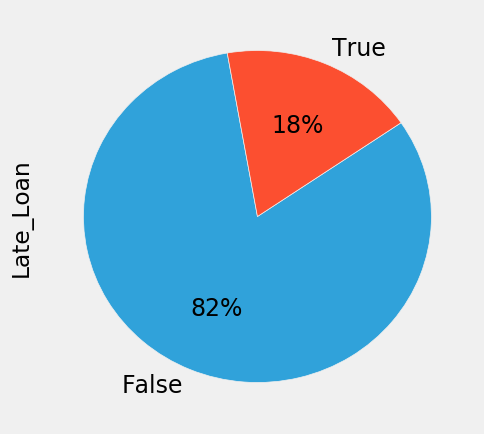

In [14]:
#distribution of our class/targer variable Late_Loan , True if loan is late. 
plt.figure(figsize=(5,5))
df_sample['Late_Loan'].value_counts().plot(kind = 'pie',autopct='%.0f%%', startangle=100, fontsize=17)
plt.show()

In [15]:
Amount_By_Year = df_sample.groupby(df_sample['issue_d'].dt.year)['loan_amnt'].mean()
Amount_By_Year = pd.DataFrame(Amount_By_Year)
Amount_By_Year['YoY Change %'] = Amount_By_Year.pct_change()*100
Amount_By_Year.rename(columns = {'loan_amnt':'Average Loan Amount'})

,Average Loan Amount,YoY Change %
issue_d,,
2007,9105.580357,NaN
2008,9246.024735,1.542399
2009,9824.119467,6.252360
2010,10582.349537,7.718046
2011,11607.049291,9.683103
2012,12936.308792,11.452174
2013,14403.558354,11.342104
2014,14231.496786,-1.194577
2015,14497.160248,1.866729


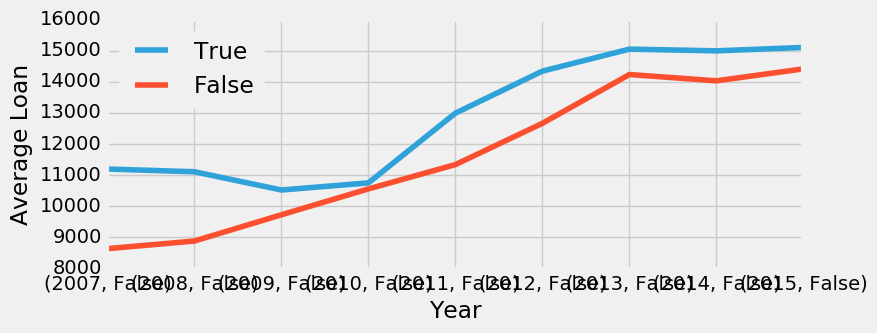

In [16]:
plt.figure(figsize=(8,3))
Amount_By_Year_Status_True = df_sample.groupby([df_sample['issue_d'].dt.year,df_sample['Late_Loan'][df_sample['Late_Loan'] == True]])['loan_amnt'].mean().plot(kind = 'line', label = 'True')
Amount_By_Year_Status_False = df_sample.groupby([df_sample['issue_d'].dt.year,df_sample['Late_Loan'][df_sample['Late_Loan'] == False]])['loan_amnt'].mean().plot(kind = 'line',label = 'False')
plt.xlabel('Year')
plt.ylabel('Average Loan')
plt.legend(loc='best')
plt.show()


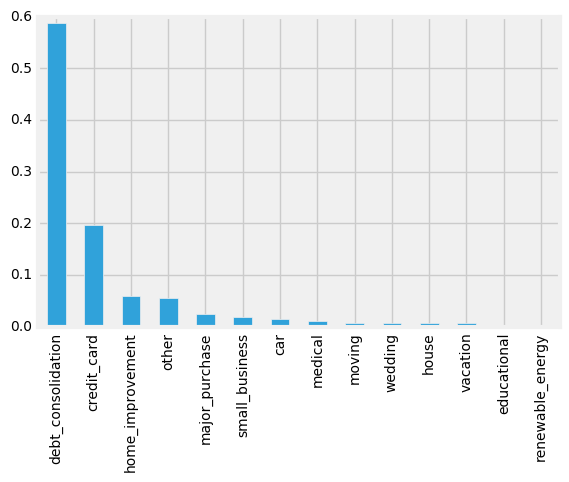

In [41]:
#This graph normalizes the purpose variables, using value counts.
#This gives us an idea of what percentage and purpose the clients are taking out loans for.
all_rows = df_sample['purpose']
pur = df_sample['purpose'].value_counts()
purp = pur/len(all_rows)
purp.plot(kind='bar')

In [128]:
flat = pur/len(df_sample['purpose']) * 100
print flat

debt_consolidation    58.718130
credit_card           19.765145
home_improvement       5.891916
other                  5.645436
major_purchase         2.447317
small_business         1.866516
car                    1.442606
medical                1.134069
moving                 0.790571
wedding                0.780082
house                  0.655094
vacation               0.632369
educational            0.124551
renewable_energy       0.106196
Name: purpose, dtype: float64


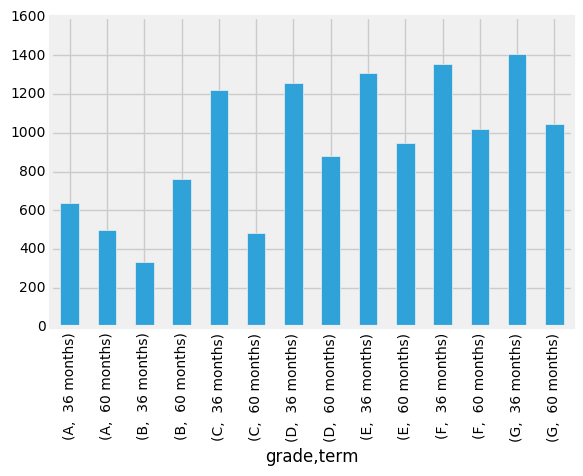

In [117]:
#I'm going to look at the installment payments against the grade and term of the loan.
#This pivot table shows the installment payments by grade and term.
loan_g = pd.pivot_table(df_sample,
                           index= ['grade','term'],
                           columns= ['installment'] ,
                            values= 'loan_amnt',
                           aggfunc = sum)
loan_g.T.idxmax()
loan_g.T.idxmax().plot(kind='bar')

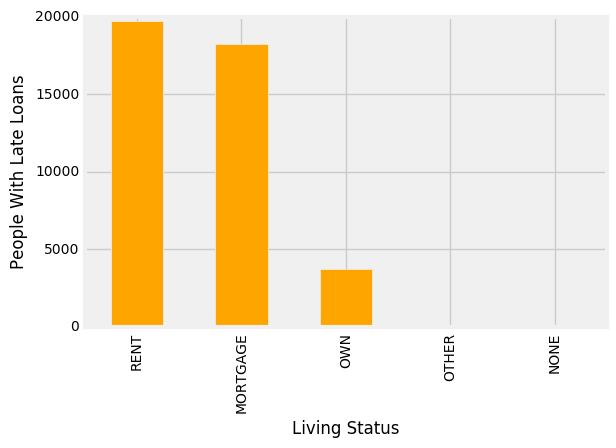

In [166]:
#This graph looks at the people who are late on their loans, renters and people paying their mortages tend to be late on payments
#A possible reason may be that the owners, others, and none may not have a financial burden.
late = df_sample[['home_ownership', 'Late_Loan']]
late_people = late['Late_Loan']== True
people = late[late_people]
sad = people['home_ownership'].value_counts().plot(kind='bar', color= 'orange')
xlabel('Living Status')
ylabel('People With Late Loans')